In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [115]:
med_df = pd.read_csv("/content/drive/MyDrive/insurance.csv")

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
#inspect data
med_df.info()
med_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [118]:
missing_count = med_df.isnull().sum()
print(missing_count)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [119]:
#check datatypes
print(med_df.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [123]:
num_columns=med_df.select_dtypes(include=['float64','int64']).columns
num_columns=[col for col in num_columns if col.lower() != 'id']
print(num_columns)

['age', 'bmi', 'children', 'charges']


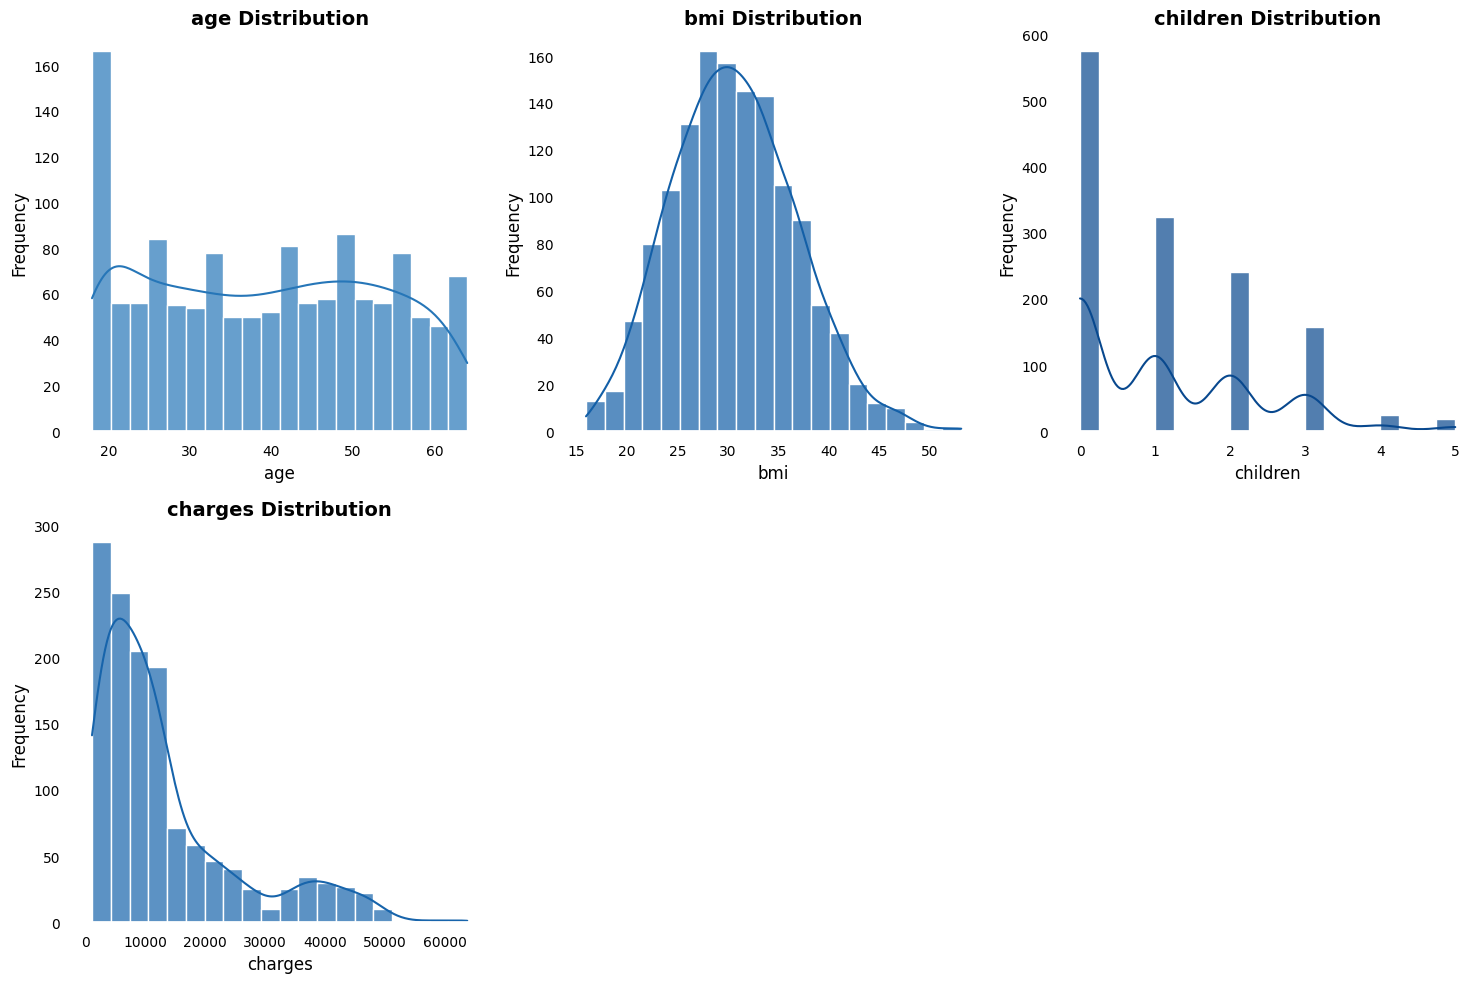

In [124]:
#Data Visualization
#histogram
sns.set(style="darkgrid")
num_cols=len(num_columns)
num_rows=(num_cols//3)+(num_cols%3>0)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axes = axes.flatten()

colors = sns.color_palette('Blues', num_cols)
dark_colors = sns.color_palette("Blues", 10)[7:10]
colors[:3] = dark_colors

for i, col in enumerate(num_columns):
  sns.histplot(med_df[col], kde = True, bins = 20, color = colors[i], ax = axes[i], alpha= 0.7)
  axes[i].set_title(f'{col} Distribution', fontsize=14, fontweight='bold', color='black')
  axes[i].set_xlabel(col, fontsize=12, color='black')
  axes[i].set_ylabel('Frequency', fontsize=12, color='black')
  axes[i].tick_params(axis='both', which='major', labelsize=10, colors='black')
  axes[i].set_facecolor('white')

for i in range(num_cols, len(axes)):
  fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [125]:
cat_columns = med_df.select_dtypes(include=['object']).columns
cat_columns= [col for col in cat_columns if col.lower()!="id"]

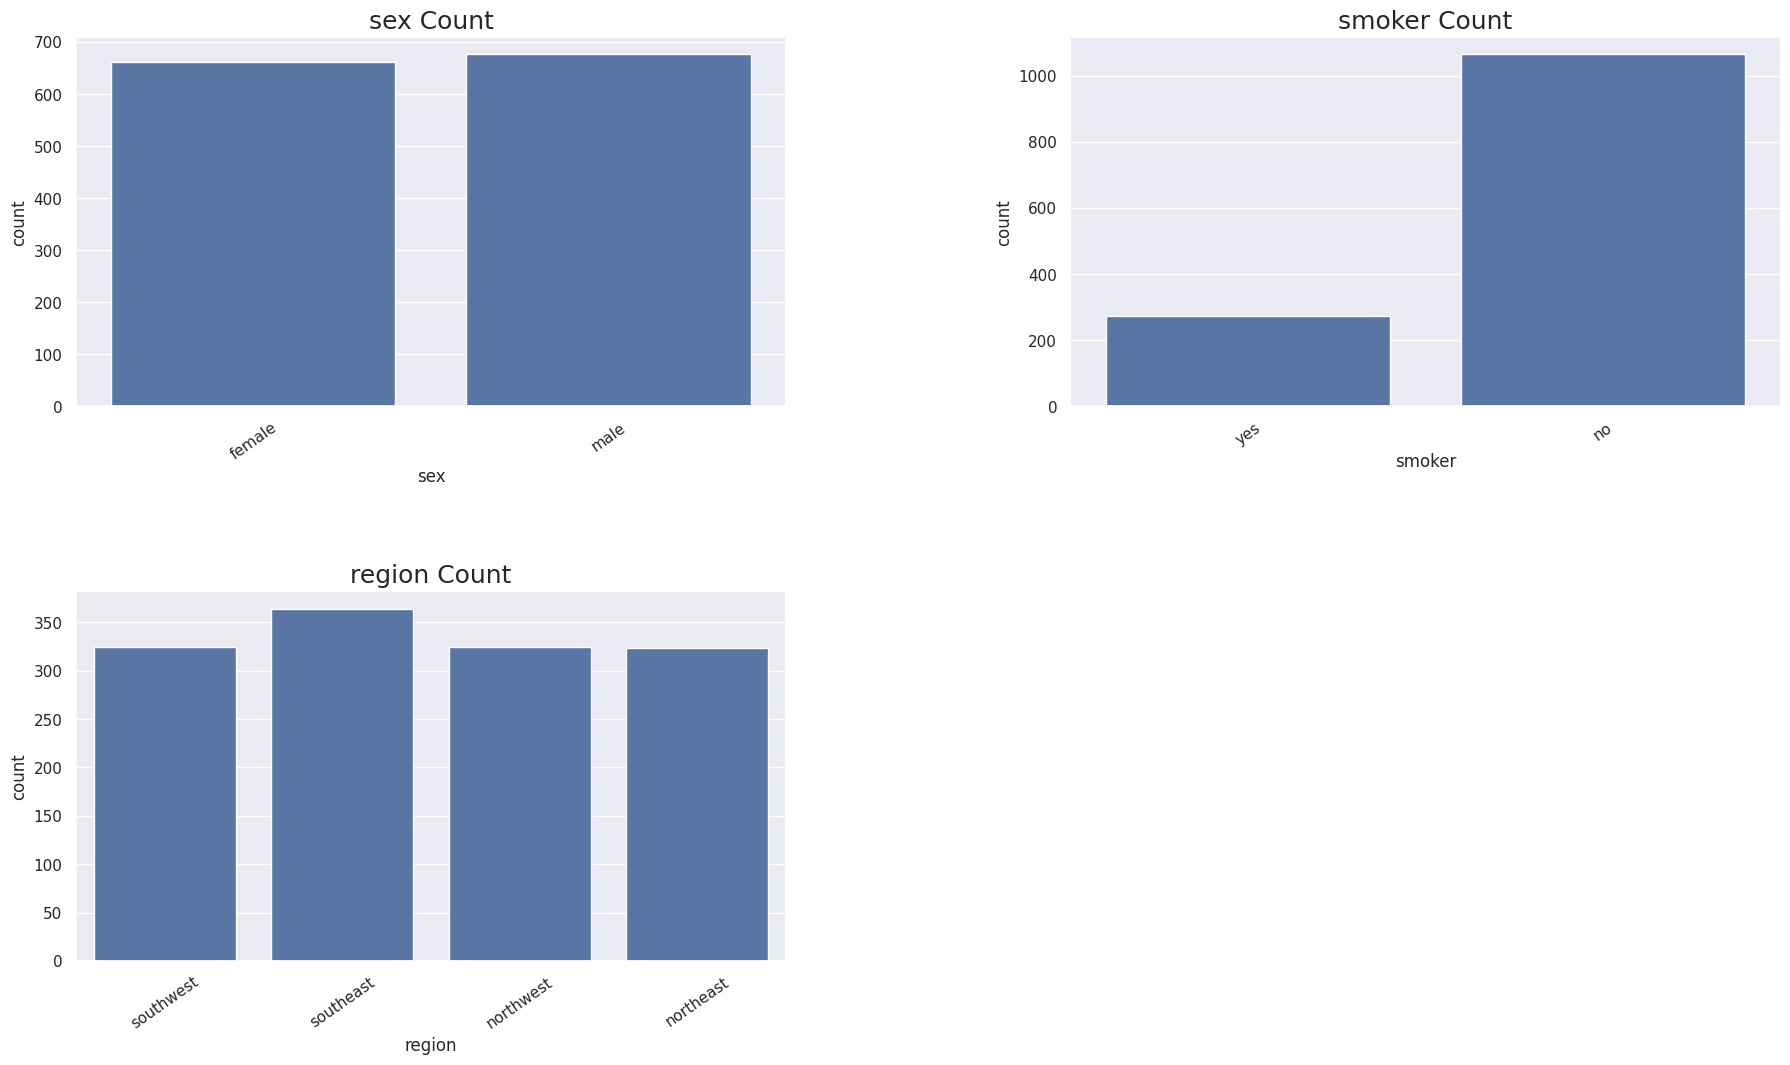

In [126]:
# Get categorical columns and exclude 'id'
#Count plot
categorical_columns = med_df.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col.lower() != 'id']

# Determine rows and columns for the subplot grid
num_cols = 2  # Two plots per row
num_rows = (len(categorical_columns) // num_cols) + (len(categorical_columns) % num_cols > 0)

# Create figure and axes
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(22, 6 * num_rows))
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot count plots for each categorical column
for i, col in enumerate(categorical_columns):
    sns.countplot(data=med_df, x=col, ax=axes[i])
    axes[i].set_title(f'{col} Count', fontsize=18)
    axes[i].tick_params(axis='x', rotation=35)

# Remove unused axes if any
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Show the plot
plt.show()

Outliers detected:
age


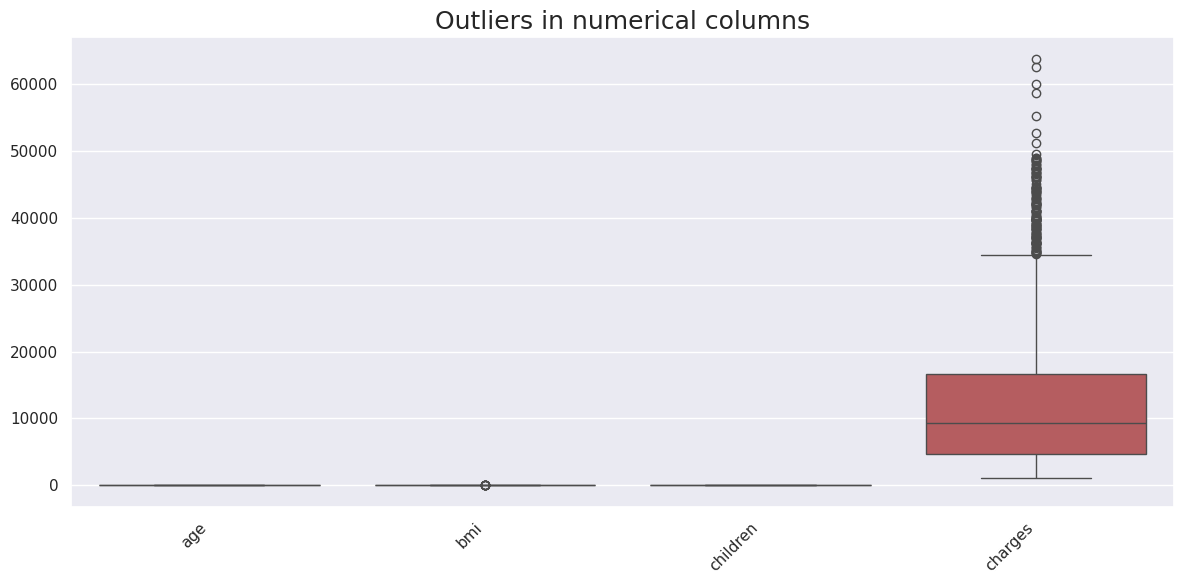

In [128]:
#Boxplot of numerical columns
num_columns = med_df.select_dtypes(include=['float64', 'int64']).columns
num_columns = [col for col in num_columns if col.lower() != 'id']

def outliers(df, num_columns):
  outliers = {}
  for col in num_columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers
num_outliers = outliers(med_df, num_columns)
print(f"Outliers detected:")
for col, outliers_df in num_outliers.items():
  print(col)

plt.figure(figsize=(12,6))
sns.boxplot(data = med_df[num_columns])
plt.title("Outliers in numerical columns", fontsize = 18)
plt.xticks(rotation = 45, ha="right")
plt.tight_layout()
plt.show()

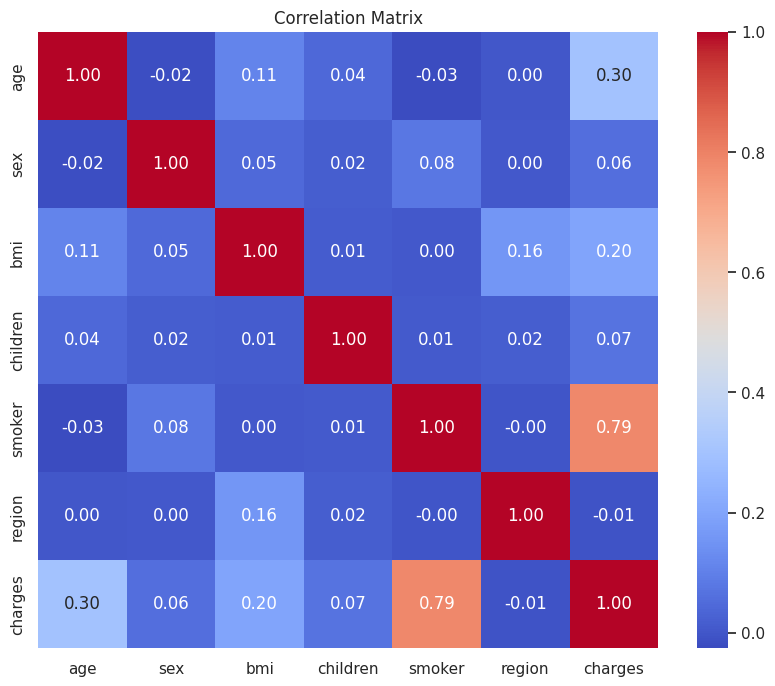

In [162]:
 #Calculate the correlation matrix
correlation_matrix = med_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt = ".2f")
plt.title('Correlation Matrix')
plt.show()

In [133]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical features
med_df['sex'] = label_encoder.fit_transform(med_df['sex'])
med_df['smoker'] = label_encoder.fit_transform(med_df['smoker'])
med_df['region'] = label_encoder.fit_transform(med_df['region'])


In [134]:
# Define features and target
X = med_df.drop(columns=['charges'])
y = med_df['charges']

In [135]:
class LinearRegression:
    def __init__(self):
        self.theta = None

    def fit(self, X, y):
        # Add a bias (intercept) term to the features
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # add x0 = 1 to each instance
        # Calculate theta using the Normal Equation
        self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def predict(self, X):
        # Add a bias (intercept) term to the features
        X_b = np.c_[np.ones((X.shape[0], 1)), X]  # add x0 = 1 to each instance
        return X_b.dot(self.theta)

    def mean_absolute_error(self, y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))

    def r2_score(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        return 1 - (ss_residual / ss_total)

    def root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [144]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the LinearRegression class
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions on training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [145]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [146]:

# Make predictions on training and testing data
y_train_pred_rf = rf_model.predict(X_train)  # Predict on training data
y_test_pred_rf = rf_model.predict(X_test)    # Predict on testing data

# Evaluate the Random Forest model on training data
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Evaluate the Random Forest model on testing data
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
r2_test_rf = r2_score(y_test, y_test_pred_rf)

# Print the results
print(f"Training Data - MAE: {mae_train_rf:.2f}, RMSE: {rmse_train_rf:.2f}, R²: {r2_train_rf:.2f}")
print(f"Testing Data - MAE: {mae_test_rf:.2f}, RMSE: {rmse_test_rf:.2f}, R²: {r2_test_rf:.2f}")

Training Data - MAE: 1053.59, RMSE: 1925.62, R²: 0.97
Testing Data - MAE: 2533.67, RMSE: 4590.57, R²: 0.86


In [147]:
# Make predictions on the training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on training data
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model on testing data
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print("Random Forest Regression Performance:")
print("Training Data:")
print(f"Mean Absolute Error: {mae_train:.2f}")
print(f"Root Mean Squared Error: {rmse_train:.2f}")
print(f"R-squared: {r2_train:.2f}\n")

print("Testing Data:")
print(f"Mean Absolute Error: {mae_test:.2f}")
print(f"Root Mean Squared Error: {rmse_test:.2f}")
print(f"R-squared: {r2_test:.2f}")

Random Forest Regression Performance:
Training Data:
Mean Absolute Error: 1053.59
Root Mean Squared Error: 1925.62
R-squared: 0.97

Testing Data:
Mean Absolute Error: 2533.67
Root Mean Squared Error: 4590.57
R-squared: 0.86


In [148]:
# Initialize and train the Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust the alpha parameter for regularization strength
lasso_model.fit(X_train, y_train)

# Make predictions on the training and test sets for Lasso
y_train_pred_lasso = lasso_model.predict(X_train)
y_test_pred_lasso = lasso_model.predict(X_test)

In [149]:
# Evaluate the Lasso model
mae_train_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)

mae_test_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

# Print the evaluation metrics for Lasso Regression
print("Lasso Regression Performance:")
print("Training Data:")
print(f"Mean Absolute Error: {mae_train_lasso:.2f}")
print(f"Root Mean Squared Error: {rmse_train_lasso:.2f}")
print(f"R-squared: {r2_train_lasso:.2f}\n")

print("Testing Data:")
print(f"Mean Absolute Error: {mae_test_lasso:.2f}")
print(f"Root Mean Squared Error: {rmse_test_lasso:.2f}")
print(f"R-squared: {r2_test_lasso:.2f}")

Lasso Regression Performance:
Training Data:
Mean Absolute Error: 4208.80
Root Mean Squared Error: 6105.79
R-squared: 0.74

Testing Data:
Mean Absolute Error: 4186.58
Root Mean Squared Error: 5799.62
R-squared: 0.78


In [150]:
# Define the parameter grid
lasso_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Initialize GridSearchCV
lasso_grid_search = GridSearchCV(estimator=lasso_model, param_grid=lasso_param_grid,
                                  scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
lasso_grid_search.fit(X_train, y_train)

# Best parameters for Lasso
best_lasso_params = lasso_grid_search.best_params_
print("Best Hyperparameters for Lasso Regression:")
print(best_lasso_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters for Lasso Regression:
{'alpha': 100}


In [151]:
# Feature Selection with Random Forest
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importance scores
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importances
})

# Sort features by importance (descending order)
rf_feature_importance_df = rf_feature_importance_df.sort_values(by="Importance", ascending=False)

# Print sorted feature importance
print("\nFeature scores for Random Forest:\n", rf_feature_importance_df)


Feature scores for Random Forest:
     Feature  Importance
4    smoker    0.608618
2       bmi    0.216291
0       age    0.134554
3  children    0.020199
5    region    0.013926
1       sex    0.006412


In [152]:
# Feature Selection with Lasso Regression
# Train Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

# Get feature coefficients
lasso_coefficients = lasso_model.coef_

# Create a DataFrame with feature names and their coefficients
lasso_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Lasso Coefficient': lasso_coefficients
})

# Sort features by importance (absolute value of coefficients)
lasso_feature_importance_df = lasso_feature_importance_df.reindex(
    lasso_feature_importance_df['Lasso Coefficient'].abs().sort_values(ascending=False).index
)

# Print sorted feature importance
print("\nFeature scores for Lasso Regression:\n", lasso_feature_importance_df)



Feature scores for Lasso Regression:
     Feature  Lasso Coefficient
4    smoker       23647.170431
3  children         425.024815
2       bmi         335.775548
5    region        -271.198180
0       age         257.055512
1       sex         -18.347228


In [156]:
# Rebuild Random Forest Regressor with optimal hyperparameters
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the training and test sets for Random Forest
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

In [160]:
# Evaluate the Random Forest model
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
r2_train_rf = r2_score(y_train, y_train_pred_rf)

mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
r2_test_rf = r2_score(y_test, y_test_pred_rf)

In [161]:
# Print the evaluation metrics for Random Forest
print("Random Forest Regression Performance:")
print("Training Data:")
print(f"Mean Absolute Error: {mae_train_rf:.2f}")
print(f"Root Mean Squared Error: {rmse_train_rf:.2f}")
print(f"R-squared: {r2_train_rf:.2f}\n")

print("Testing Data:")
print(f"Mean Absolute Error: {mae_test_rf:.2f}")
print(f"Root Mean Squared Error: {rmse_test_rf:.2f}")
print(f"R-squared: {r2_test_rf:.2f}\n")

Random Forest Regression Performance:
Training Data:
Mean Absolute Error: 1053.41
Root Mean Squared Error: 1925.55
R-squared: 0.97

Testing Data:
Mean Absolute Error: 2534.89
Root Mean Squared Error: 4590.98
R-squared: 0.86

